In [ ]:
%config Completer.use_jedi = False

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Bibliotheken importieren detecting Indian hate tweets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, Activation, InputLayer
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import keras.backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import pickle

import matplotlib.pyplot as plt
import numpy as np
import os

# Vorverarbeitung

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [8]:
TARGETSIZE = (224,224)
INPUTSHAPE = (224,224,3)
BATCHSIZE = 64
N_CLASSES = 4

train_data  = train_datagen.flow_from_directory(directory = "/content/drive/MyDrive/Data/train",
                                                target_size = TARGETSIZE,
                                                class_mode = 'categorical',
                                                batch_size = BATCHSIZE)

valid_data = valid_datagen.flow_from_directory(directory = "/content/drive/MyDrive/Data/valid",
                                                target_size = TARGETSIZE,
                                                class_mode = 'categorical',
                                                batch_size = BATCHSIZE)

test_data = test_datagen.flow_from_directory(directory = "/content/drive/MyDrive/Data/test",
                                                target_size = TARGETSIZE,
                                                class_mode = 'categorical',
                                                batch_size = BATCHSIZE)
true_labels = test_data.labels

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


## Klassengewichte

In [9]:
# Get list of class weights
class_weights_list = class_weight.compute_class_weight(
           class_weight='balanced',
            classes=np.unique(train_data.classes),
            y=train_data.classes)
# Get class labels
class_labels=np.unique(train_data.classes)

# Put weights in dict with class label
class_weights = {}
for class_i in range(len(class_labels)):
     class_weights[class_labels[class_i]] = class_weights_list[class_i]

# Check
class_weights

{0: 0.7858974358974359,
 1: 1.3326086956521739,
 2: 1.035472972972973,
 3: 0.9887096774193549}

# CNN Implementierungen

## Preparation

### Metrics

In [4]:
## Mal gucken, ob man das hier nicht mit was besserem und implementierten ersetzen kann bzw. das überhaupt braucht.
# Matrix wäre wichtig! JL
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

### Plotting of metrics

In [5]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,precision,val_precision,):
    # Plotten der Training-Hostorie
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(precision) + 1), precision)
    ax3.plot(range(1, len(val_precision) + 1), val_precision)
    ax3.set_title('History of Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend(['training', 'validation'])

    plt.show()

In [10]:
def ConfusionMatrix(predictions,true_labels , title):

    predicted_labels = np.argmax(predictions, axis=1)
    cm = confusion_matrix(true_labels, predicted_labels)

    class_labels = test_data.class_indices.keys()

    # Plot confusion matrix
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=90)
    plt.yticks(tick_marks, class_labels)


    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

Der nachfolgende Code dient dazu gespeicherte Modelle und deren Historien aus dem Speicher zu löschen. Da dies aktuell nicht erwünscht ist, ist dieser Codeteil auskommentiert. Die Kommentierung kann bei Bedarf wieder entfernt werden

# AlexNet

In [11]:

from tensorflow.keras import backend
backend.clear_session()

In [12]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

def AlexNet():
    # Create the AlexNet model
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), input_shape=INPUTSHAPE, padding="valid"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Layer 2
    model.add(Conv2D(256, kernel_size=(5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Layer 3
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))

    # Layer 4
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', strides=(1,1)))
    model.add(Activation('relu'))

    # Layer 5
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', strides=(1,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding='valid'))

    # Flatten the output from previous layer
    model.add(keras.layers.GlobalAveragePooling2D())

    # Layer 6
    model.add(Dense(4, activation='softmax'))

    # Print the model summary
    model.summary()

    return model


In [13]:
# get Model from File
from keras.models import load_model
import pickle

# if there is a saved model, load it, otherwise retrain
try:
    alexnet = AlexNet()
    alexnet.load_weights('./chest_CT_SCAN-Alexnet.hdf5')
    alexnet.summary()
except:
    # train a new one
    alexnet = AlexNet()

    alexnet.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = METRICS)

    early_stop = EarlyStopping(patience=20, monitor='val_loss', verbose=1, mode='min')
    checkpoint = ModelCheckpoint(filepath='./chest_CT_SCAN-Alexnet.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

    history_alexnet = alexnet.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[early_stop, checkpoint], class_weight = class_weights)
    with open('training_history_alex.pkl', 'wb') as file:
        pickle.dump(history_alexnet.history, file)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 27, 27, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                    

KeyboardInterrupt: ignored

In [ ]:
alexnet.save("")

In [14]:
alex=load_model("/content/drive/MyDrive/alexnet(1).h5")

In [15]:
result_alex = alexnet.evaluate(test_data, verbose=1)

KeyboardInterrupt: ignored

In [ ]:
predictions = alexnet.predict(test_data)

ConfusionMatrix(predictions,true_labels , "AlexNet")

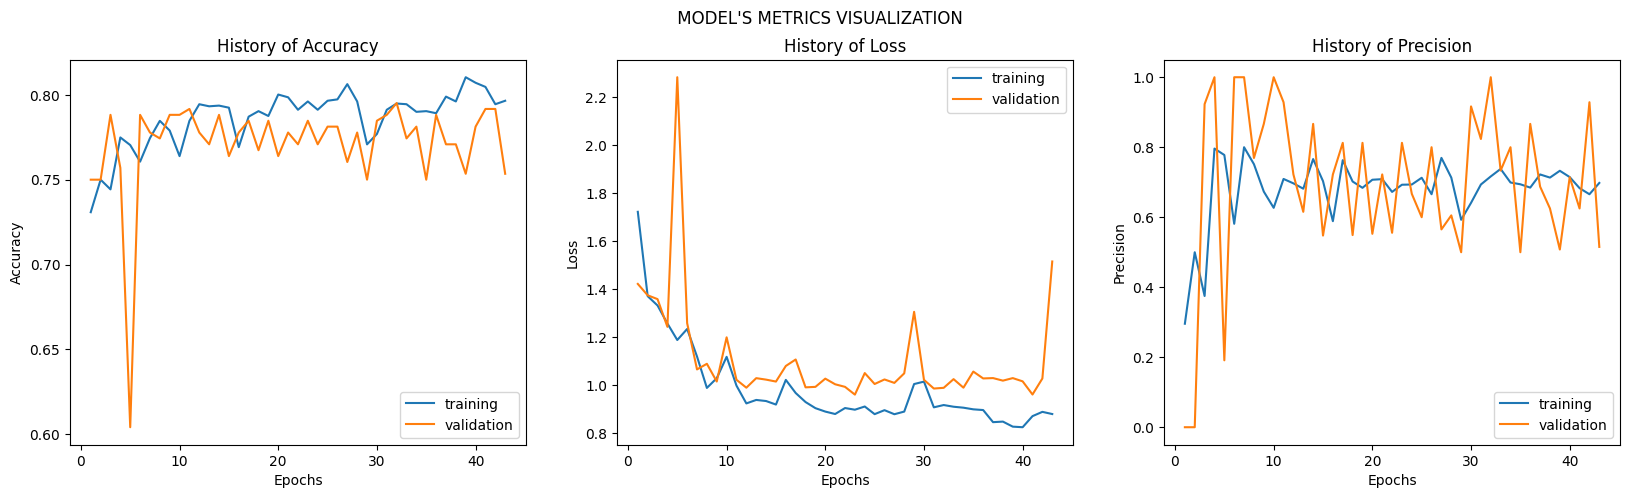

In [16]:
# load history
with open('/content/drive/MyDrive/training_history_alex.pkl', 'rb') as file:
    history_alexnet = pickle.load(file)

Train_Val_Plot(history_alexnet['accuracy'],
               history_alexnet['val_accuracy'],
               history_alexnet['loss'],
               history_alexnet['val_loss'],
               history_alexnet['precision'],
               history_alexnet['val_precision'],
              )

In [21]:
alex.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 activation_5 (Activation)   (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 activation_6 (Activation)   (None, 27, 27, 256)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                  

5/5 [==============================] - 184s 43s/step


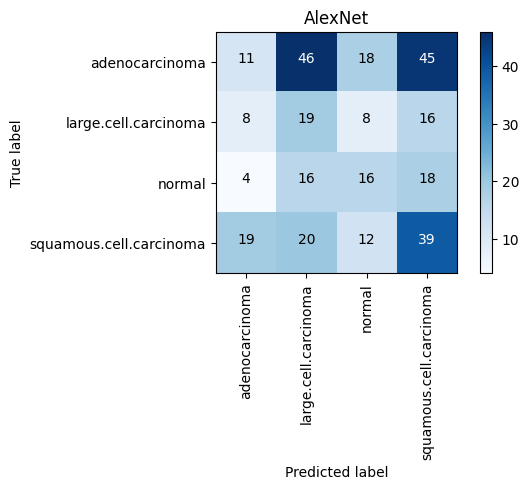

In [17]:
predictions = alex.predict(test_data)

ConfusionMatrix(predictions,true_labels , "AlexNet")

In [18]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

imag_path_1='/content/drive/MyDrive/Data/test/large.cell.carcinoma/000111.png'
img1=keras.utils.load_img(imag_path_1,target_size=(224,224))
img1=keras.utils.img_to_array(img1)
img1=np.expand_dims(img1,axis=0)
img1=preprocess_input(img1)

In [19]:
preds=alex.predict(img1)

1/1 [==============================] - 1s 574ms/step


In [20]:
preds[0][2]

1.0

In [ ]:
alex.get_layer('global_average_pooling2d_1').output

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'global_average_pooling2d_1')>

In [ ]:
model=keras.Model(
    inputs=alex.inputs,
    outputs=alex.get_layer('conv2d_9').output
)

In [ ]:
weights = alex.get_layer('dense_1').get_weights()

In [ ]:
w=weights[0][:,2]

In [ ]:
layer_output=model(img1)

In [ ]:
out=layer_output[0,:,:,:]

In [ ]:
new_image=np.zeros((13,13))

In [ ]:
for i in range(256):
  new_image=new_image+(out[:,:,i]*w[i])

In [ ]:

new_image=new_image/np.max(new_image)

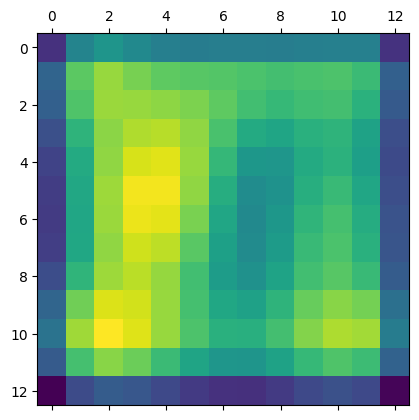

In [ ]:
plt.matshow(new_image)

In [ ]:
new_image=new_image.numpy()

In [ ]:
import cv2
imag=cv2.imread(imag_path_1)
heatmap=cv2.resize(new_image,(395,305))
super_img=heatmap*0.4+imag[:,:,1]+imag[:,:,2] +imag[:,:,0]

In [ ]:
cv2.imwrite(r'/home/adesh/Desktop/super_img.jpg' ,super_img)

False

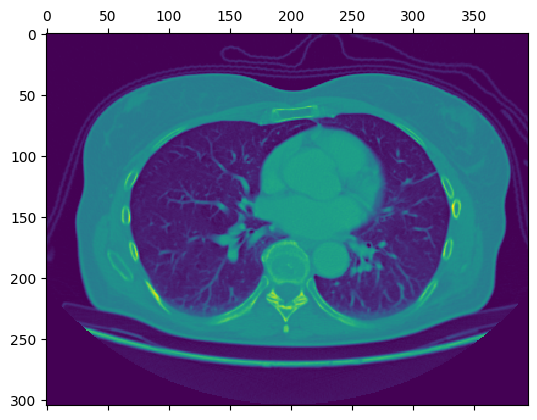

In [ ]:
plt.matshow(super_img)